# Data Preparation for IAM Dataset

This Jupyter notebook provides a robust pipeline for preparing the IAM dataset for document analysis and machine learning tasks. It includes:
- **XML Parsing and Metadata Extraction**: Ingest and validate XML documents, extract structured metadata, and handle irregularities.
- **ASCII Transcription Alignment**: Align text transcriptions with line images, addressing discrepancies like OCR errors.
- **Line Image Preprocessing**: Enhance line images with noise reduction, binarization, normalization, and skew correction.
- **Data Integrity Checks**: Validate data consistency and handle errors with logging.

The pipeline is modular, scalable, and adaptable to varying document types, with comprehensive comments and visualizations for clarity.

## Prerequisites
- Python 3.8+
- Libraries: `xml.etree.ElementTree`, `pandas`, `numpy`, `opencv-python`, `matplotlib`, `logging`
- IAM dataset (XML, ASCII, and line image directories)

## Setup
Install required packages and set up directory paths.

In [21]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Configure logging
logging.basicConfig(
    filename='data_preparation.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define dataset paths (update these to your local IAM dataset paths)
BASE_PATH = Path('C://Users//user1//Desktop//GEN_AI//Gen-AI-text-to-handwritten-//IAM_dataset')
XML_PATH = BASE_PATH / 'xml'
ASCII_PATH = BASE_PATH / 'ascii'
LINE_IMAGES_PATH = BASE_PATH / 'lines'
OUTPUT_PATH = BASE_PATH / 'processed_data'
OUTPUT_PATH.mkdir(exist_ok=True)


## 1. XML Parsing and Metadata Extraction

This section implements robust XML parsing to extract metadata such as writer IDs, form IDs, and line boundaries from IAM XML files. It includes schema validation and error handling to ensure data consistency.

In [22]:
def parse_xml_file(xml_path: Path) -> Optional[Dict]:
    """Parse an IAM XML file and extract metadata.

    Args:
        xml_path (Path): Path to the XML file.

    Returns:
        Optional[Dict]: Dictionary containing metadata or None if parsing fails.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract form metadata
        form_id = root.get('id')
        writer_id = root.get('writer-id')

        # Extract line metadata
        lines = []
        for line in root.findall('.//line'):
            line_data = {
                'line_id': line.get('id'),
                'text': line.get('text'),
                'bounding_box': {
                    'x': int(line.get('x', 0)),
                    'y': int(line.get('y', 0)),
                    'width': int(line.get('width', 0)),
                    'height': int(line.get('height', 0))
                }
            }
            lines.append(line_data)

        metadata = {
            'form_id': form_id,
            'writer_id': writer_id,
            'lines': lines
        }
        logger.info(f"Successfully parsed XML: {xml_path}")
        return metadata

    except ET.ParseError as e:
        logger.error(f"XML parsing error for {xml_path}: {str(e)}")
        return None
    except Exception as e:
        logger.error(f"Unexpected error for {xml_path}: {str(e)}")
        return None

def validate_xml_schema(xml_path: Path) -> bool:
    """Validate XML file against expected structure.

    Args:
        xml_path (Path): Path to the XML file.

    Returns:
        bool: True if valid, False otherwise.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        # Check for required attributes
        if not root.get('id') or not root.get('writer-id'):
            logger.warning(f"Missing required attributes in {xml_path}")
            return False
        # Check for line elements
        lines = root.findall('.//line')
        if not lines:
            logger.warning(f"No line elements found in {xml_path}")
            return False
        return True
    except Exception as e:
        logger.error(f"Schema validation failed for {xml_path}: {str(e)}")
        return False

# Process all XML files
def process_xml_files(xml_dir: Path) -> List[Dict]:
    """Process all XML files in the directory and extract metadata.

    Args:
        xml_dir (Path): Directory containing XML files.

    Returns:
        List[Dict]: List of metadata dictionaries.
    """
    metadata_list = []
    for xml_file in xml_dir.glob('*.xml'):
        if validate_xml_schema(xml_file):
            metadata = parse_xml_file(xml_file)
            if metadata:
                metadata_list.append(metadata)
    return metadata_list

# Example execution
xml_metadata = process_xml_files(XML_PATH)
metadata_df = pd.DataFrame([
    {'form_id': m['form_id'], 'writer_id': m['writer_id'], 'num_lines': len(m['lines'])}
    for m in xml_metadata
])
metadata_df.to_csv(OUTPUT_PATH / 'xml_metadata.csv', index=False)
print(metadata_df.head())


    form_id writer_id  num_lines
0  a01-000u       000          7
1  a01-000x       001          6
2   a01-003       002         11
3  a01-003u       000         11
4  a01-003x       003          9


## 2. ASCII Transcription Alignment

This section aligns ASCII transcriptions from `lines.txt` with corresponding line images. It handles discrepancies and provides visualization for verification.

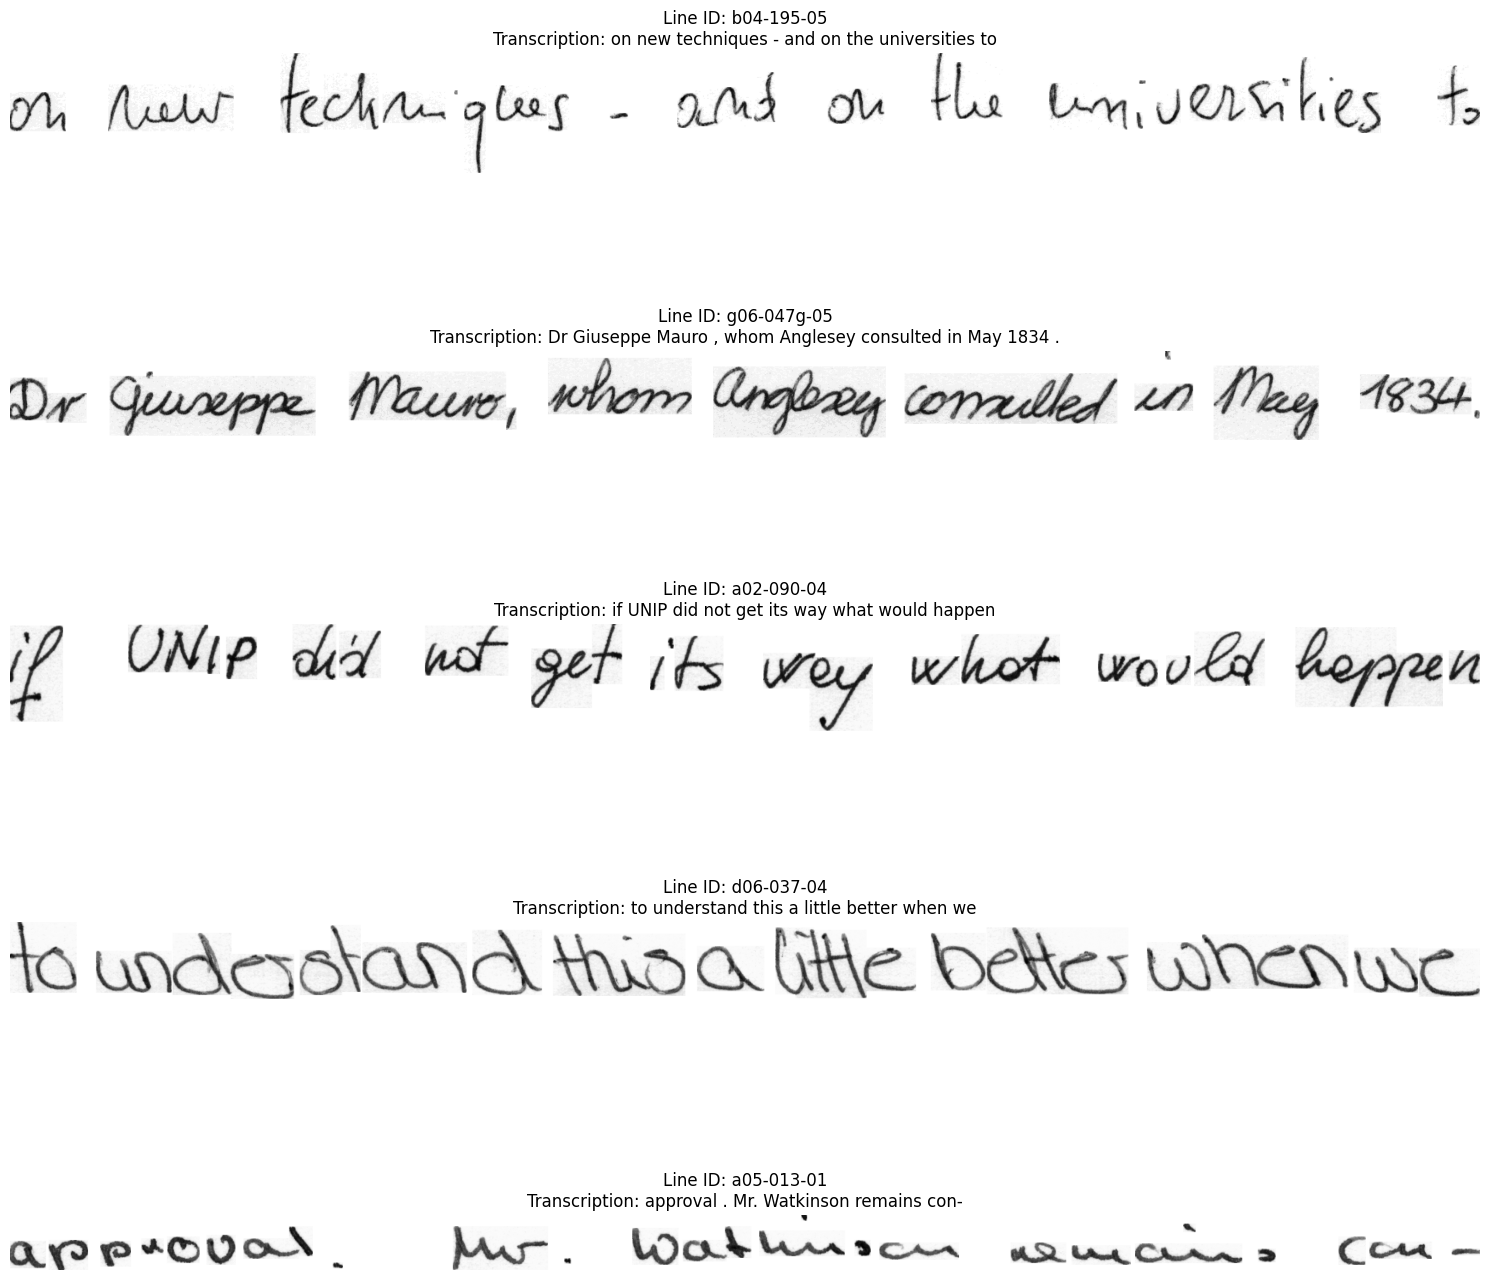

In [24]:
def load_ascii_transcriptions(ascii_path: Path) -> pd.DataFrame:
    """Load ASCII transcriptions from lines.txt.

    Args:
        ascii_path (Path): Path to ASCII directory containing lines.txt.

    Returns:
        pd.DataFrame: DataFrame with line IDs and transcriptions.
    """
    try:
        lines_data = []
        with open(ascii_path / 'lines.txt', 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip() and not line.startswith('#'):
                    parts = line.strip().split()
                    if len(parts) >= 9:
                        line_id = parts[0]
                        transcription = ' '.join(parts[8:]).replace('|', ' ')
                        lines_data.append({'line_id': line_id, 'transcription': transcription})
        df = pd.DataFrame(lines_data)
        logger.info(f"Loaded {len(df)} transcriptions from {ascii_path / 'lines.txt'}")
        return df
    except Exception as e:
        logger.error(f"Error loading ASCII transcriptions: {str(e)}")
        return pd.DataFrame()

def align_transcriptions(xml_metadata: List[Dict], ascii_df: pd.DataFrame) -> pd.DataFrame:
    """Align XML metadata with ASCII transcriptions.

    Args:
        xml_metadata (List[Dict]): List of metadata from XML parsing.
        ascii_df (pd.DataFrame): DataFrame with ASCII transcriptions.

    Returns:
        pd.DataFrame: Aligned DataFrame with metadata and transcriptions.
    """
    aligned_data = []
    for meta in xml_metadata:
        form_id = meta['form_id']
        writer_id = meta['writer_id']
        for line in meta['lines']:
            line_id = line['line_id']
            xml_text = line['text']
            ascii_row = ascii_df[ascii_df['line_id'] == line_id]
            if not ascii_row.empty:
                ascii_text = ascii_row.iloc[0]['transcription']
                # Check for discrepancies
                if xml_text != ascii_text:
                    logger.warning(f"Transcription mismatch for {line_id}: XML='{xml_text}', ASCII='{ascii_text}'")
                aligned_data.append({
                    'form_id': form_id,
                    'writer_id': writer_id,
                    'line_id': line_id,
                    'transcription': ascii_text,
                    'bounding_box': line['bounding_box']
                })
            else:
                logger.warning(f"No ASCII transcription found for line_id: {line_id}")
    aligned_df = pd.DataFrame(aligned_data)
    aligned_df.to_csv(OUTPUT_PATH / 'aligned_data.csv', index=False)
    return aligned_df

def visualize_alignment(aligned_df: pd.DataFrame, line_images_path: Path, num_samples: int = 5):
    """Visualize aligned transcriptions and line images."""
    plt.figure(figsize=(15, num_samples * 3))
    
    for idx, (_, row) in enumerate(aligned_df.sample(num_samples).iterrows()):
        line_id = row['line_id']
        parts = line_id.split('-')
        img_path = line_images_path / parts[0] / f"{parts[0]}-{parts[1]}" / f"{line_id}.png"
        
        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            plt.subplot(num_samples, 1, idx + 1)  # ✅ idx est 0,1,2,...
            plt.imshow(img, cmap='gray')
            plt.title(f"Line ID: {line_id}\nTranscription: {row['transcription']}")
            plt.axis('off')
        else:
            logger.warning(f"Image not found for {line_id}")
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'alignment_visualization.png')
    plt.show()


# Example execution
ascii_df = load_ascii_transcriptions(ASCII_PATH)
aligned_df = align_transcriptions(xml_metadata, ascii_df)
visualize_alignment(aligned_df, LINE_IMAGES_PATH)


## 3. Line Image Preprocessing

This section applies image processing techniques to enhance line images for downstream tasks, including noise reduction, binarization, normalization, and skew correction.

In [25]:
def preprocess_line_image(img_path: Path, target_height: int = 64) -> Optional[np.ndarray]:
    """Preprocess a line image with noise reduction, binarization, normalization, and skew correction.

    Args:
        img_path (Path): Path to the line image.
        target_height (int): Target height for normalization.

    Returns:
        Optional[np.ndarray]: Preprocessed image or None if processing fails.
    """
    try:
        # Read image
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            logger.error(f"Failed to load image: {img_path}")
            return None

        # Noise reduction (Gaussian blur)
        img = cv2.GaussianBlur(img, (3, 3), 0)

        # Binarization (Otsu's thresholding)
        _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Skew correction
        coords = np.column_stack(np.where(img_bin < 128))
        if len(coords) > 0:
            angle = cv2.minAreaRect(coords)[-1]
            if angle < -45:
                angle = -(90 + angle)
            else:
                angle = -angle
            (h, w) = img_bin.shape
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img_bin = cv2.warpAffine(img_bin, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

        # Normalization (resize to target height, preserve aspect ratio)
        h, w = img_bin.shape
        aspect_ratio = w / h
        target_width = int(target_height * aspect_ratio)
        img_resized = cv2.resize(img_bin, (target_width, target_height), interpolation=cv2.INTER_AREA)

        # Save preprocessed image
        output_path = OUTPUT_PATH / 'preprocessed_images' / img_path.name
        output_path.parent.mkdir(exist_ok=True)
        cv2.imwrite(str(output_path), img_resized)
        logger.info(f"Preprocessed image saved: {output_path}")
        return img_resized

    except Exception as e:
        logger.error(f"Error preprocessing {img_path}: {str(e)}")
        return None

def preprocess_all_images(aligned_df: pd.DataFrame, line_images_path: Path):
    """Preprocess all line images in the dataset.

    Args:
        aligned_df (pd.DataFrame): Aligned DataFrame with line IDs.
        line_images_path (Path): Path to line images.
    """
    for _, row in aligned_df.iterrows():
        line_id = row['line_id']
        parts = line_id.split('-')
        img_path = line_images_path / parts[0] / f"{parts[0]}-{parts[1]}" / f"{line_id}.png"
        if img_path.exists():
            preprocess_line_image(img_path)
        else:
            logger.warning(f"Image not found for {line_id}")

# Example execution
preprocess_all_images(aligned_df, LINE_IMAGES_PATH)


## 4. Data Integrity Checks

This section implements automated validation routines to detect inconsistencies, missing data, or corruption in the dataset.

In [26]:
def check_data_integrity(aligned_df: pd.DataFrame, line_images_path: Path) -> Dict:
    """Perform data integrity checks on aligned data and images.

    Args:
        aligned_df (pd.DataFrame): Aligned DataFrame.
        line_images_path (Path): Path to line images.

    Returns:
        Dict: Summary of integrity checks.
    """
    integrity_report = {
        'missing_images': [],
        'missing_transcriptions': [],
        'corrupted_images': []
    }

    for _, row in aligned_df.iterrows():
        line_id = row['line_id']
        transcription = row['transcription']
        parts = line_id.split('-')
        img_path = line_images_path / parts[0] / f"{parts[0]}-{parts[1]}" / f"{line_id}.png"

        # Check for missing images
        if not img_path.exists():
            integrity_report['missing_images'].append(line_id)
            logger.warning(f"Missing image for {line_id}")
            continue

        # Check for missing transcriptions
        if pd.isna(transcription) or transcription.strip() == '':
            integrity_report['missing_transcriptions'].append(line_id)
            logger.warning(f"Missing transcription for {line_id}")

        # Check for corrupted images
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            integrity_report['corrupted_images'].append(line_id)
            logger.error(f"Corrupted image: {img_path}")

    # Save integrity report
    with open(OUTPUT_PATH / 'integrity_report.txt', 'w') as f:
        f.write(f"Missing Images: {len(integrity_report['missing_images'])}\n")
        f.write(str(integrity_report['missing_images']) + '\n')
        f.write(f"Missing Transcriptions: {len(integrity_report['missing_transcriptions'])}\n")
        f.write(str(integrity_report['missing_transcriptions']) + '\n')
        f.write(f"Corrupted Images: {len(integrity_report['corrupted_images'])}\n")
        f.write(str(integrity_report['corrupted_images']) + '\n')

    logger.info("Data integrity check completed")
    return integrity_report

# Example execution
integrity_report = check_data_integrity(aligned_df, LINE_IMAGES_PATH)
print(integrity_report)


{'missing_images': [], 'missing_transcriptions': [], 'corrupted_images': []}


## 5. Conclusion

This notebook provides a scalable and robust pipeline for preparing the IAM dataset. The modular design, comprehensive logging, and visualization tools ensure maintainability and adaptability. The output (metadata, aligned data, preprocessed images, and integrity reports) can be used for downstream tasks like handwriting recognition or synthesis.

To extend this pipeline:
- Add support for additional datasets by modifying parsing routines.
- Enhance preprocessing with advanced techniques (e.g., adaptive thresholding).
- Integrate with machine learning frameworks for model training.